# Revenue Prediction with Cohort Analysis with BART

This notebook is inspired and largely based on the [article](https://juanitorduz.github.io/revenue_retention/) by Dr Juan Orduz. We work with an anonymized dataset of online transactions from the period 2021-2024 and forecast future revenue. 

## Project background
The goal of this project was to help our client create and backtest a revenue forecasting model for potential investment targets. 

The client is a direct lending fund. The model is intended to help the client assess investment targets, and help the client understand the targets' already acquired customers, and how much value they are likely to generate in the next 12 months. 

The dataset used in this notebook comes from a DTC fashion retailer, from Jan'21 to Oct'24. 

## Project approach
Week 1: EDA (some visualizations are replicated below). Customer segmentation (behavioral segmentation using KMeans).
Week 2: BG/NBD & Gamma/Gamma modeling (non-Bayesian and no time-varying covariates)
Week 3: BART modeling
Week 4 - 5: further BART modeling, refining, and backtesting
    - Modifying hyperparameters
    - Modifying amount of training data (using all available data for training vs using only 1 year of data)
    - Fitting a BART component for both revenue and number of users
    - Fitting a linear model for number of users 
    - Using posteriors as priors in subsequent training
    - Adding seasonality component and interaction terms to the revenue component
    - SARIMAX
    - NumPyro
Week 6: BG/NBD with time varying covariates (work in progress, takes very long to fit)

## Modeling evaluation & Backtesting
We evaluated models by looking at 
- out-of-sample revenue prediction 
    - e.g. using pre Jan'24 data as training, we compare observed revenue for acquired cohorts from Jan'24 to Oct'24 against predicted mean revenue and prediction interval. 
    - looking for 1) ability to capture seasonal trend 2) ability to capture observed value within prediction interval
    - we calculate 1) *mean absolute percentage error* and 2) *HDI coverage*
- forward revenue prediction
    - e.g. using pre Jan'23 data as training, we compare the observed forward revenue for Jan'23 to Jan'24 against the predicted revenue and prediction interval 

## General takeaways
- BART is best able to capture seasonal trend, while also being relatively quick to train 
- Model seems to perform slightly better with additional seasonality coefficients in the revenue component 
- SARIMAX, BG/NBD (no covariates) did a poor job at fitting to data. 
- NumPyro was much faster to train, but did not seem to perform as well as BART. 

## Notebook Setup

In [2]:
import project_utils
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import graphviz
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import xarray as xr
import seaborn as sns
import pandas as pd

import pymc as pm 
import pymc_bart as pmb
import pytensor
import pytensor.tensor as pt

from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule
from scipy.special import logit
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.metrics import (
    mean_absolute_percentage_error
)
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, module="pymc")

## Data loading & Preprocessing

In our dataset we observe order level data. For each order entry, we have an associated date, order timestamp, customer ID, and revenue.

In [2]:
transactions = project_utils.load_transactions('./transactions.csv')
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00
...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00


We get a feel of our dataset by taking some summary statistics

In [3]:
print(f"Dataset contains {transactions.shape[0]} entries") 
print(f"Number of unique order id: {len(transactions['ORDER_KEY'].unique())}")
print(f"Number of unique customers: {len(transactions['CUSTOMER_KEY'].unique())}")
print(f"Starting date: {transactions['DATE_KEY'].min()}")
print(f"Starting date: {transactions['DATE_KEY'].max()}")

Dataset contains 630398 entries
Number of unique order id: 630398
Number of unique customers: 206243
Starting date: 2021-01-01 00:00:00
Starting date: 2024-10-18 00:00:00


The majority of orders are between $0 to $500. We plot a histogram of order value in log scale to visualize distribution of individual order level.

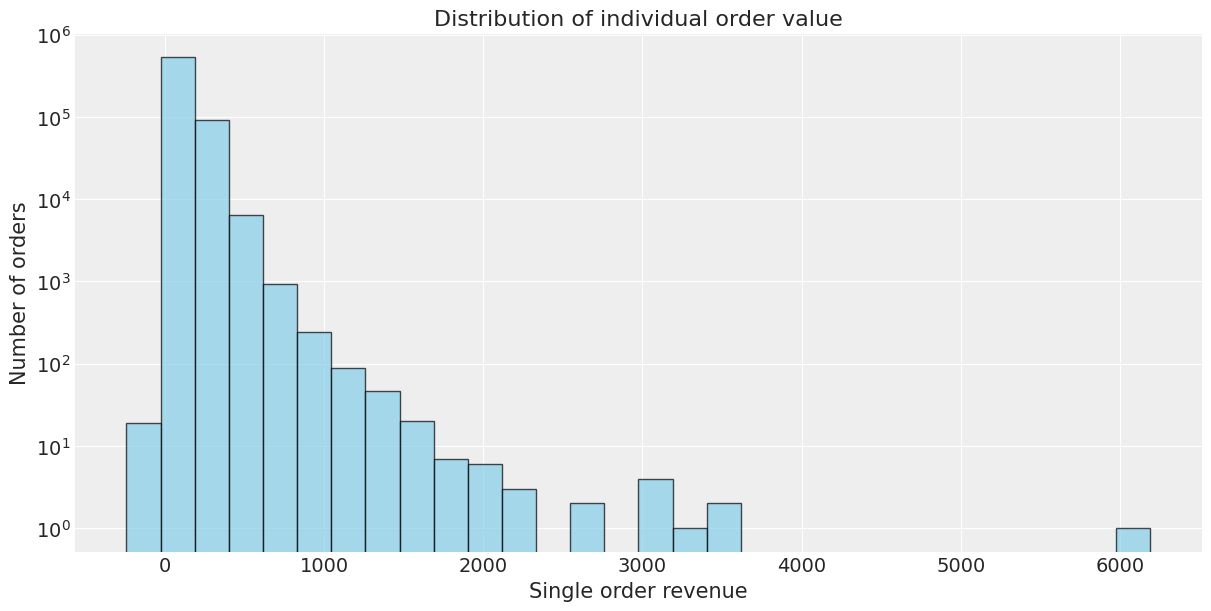

In [4]:
plt.figure(figsize=(12, 6))
plt.hist(
    transactions['FULL_REVENUE'],
    log=True,
    color='skyblue',
    edgecolor='black',
    alpha = .7,
    bins = 30,
)
plt.title("Distribution of individual order value")
plt.xlabel("Single order revenue")
plt.ylabel("Number of orders")
plt.show()

The majority of customers are "once and gone"

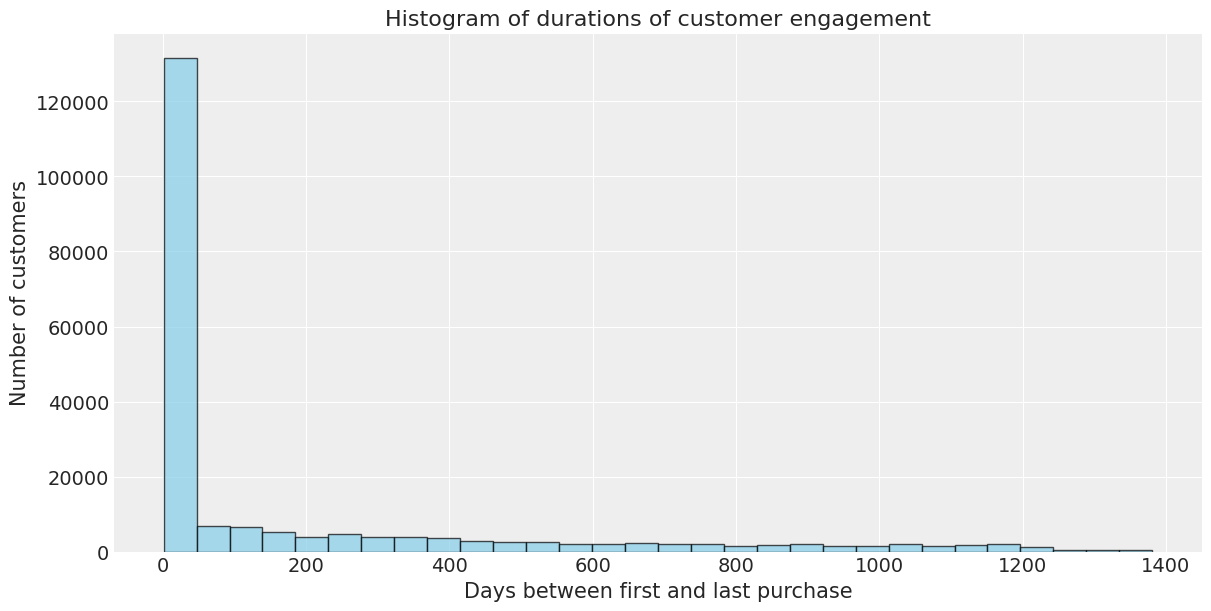

Number of customers who spent only once: 115913( 56.20 % of dataset)


In [5]:
customer_engagement = transactions.groupby(
    by='CUSTOMER_KEY',
)['DATE_KEY'].apply(lambda x: x.max() - x.min())
customer_engagement

t = customer_engagement / pd.to_timedelta('1d')
t += 1
plt.figure(figsize=(12, 6))
plt.hist(
    t,
    color='skyblue',
    edgecolor='black',
    alpha = .7,
    bins = 30,
)
plt.title("Histogram of durations of customer engagement")
plt.xlabel("Days between first and last purchase")
plt.ylabel("Number of customers")
plt.show()

print(f"""Number of customers who spent only once: {
    sum(t == 1)
}({sum(t == 1) * 100 / t.size: .2f} % of dataset)""")

We assign each order with a week, month, and cohort label.

Cohorts are assigned based on the month of first purchase.

In [8]:
transactions = project_utils.preprocess_transactions(transactions)
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00,2021-07-12,2021-07-01,2021-07-01
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00,2021-05-31,2021-06-01,2021-06-01
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00,2021-06-21,2021-06-01,2021-06-01
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00,2021-07-12,2021-07-01,2021-06-01
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00,2021-07-26,2021-07-01,2021-06-01
...,...,...,...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00,2023-02-20,2023-02-01,2021-05-01
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00,2023-03-13,2023-03-01,2021-05-01
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00,2023-04-10,2023-04-01,2021-05-01
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00,2023-05-22,2023-05-01,2021-05-01


We observe some seasonality effects in our dataset.

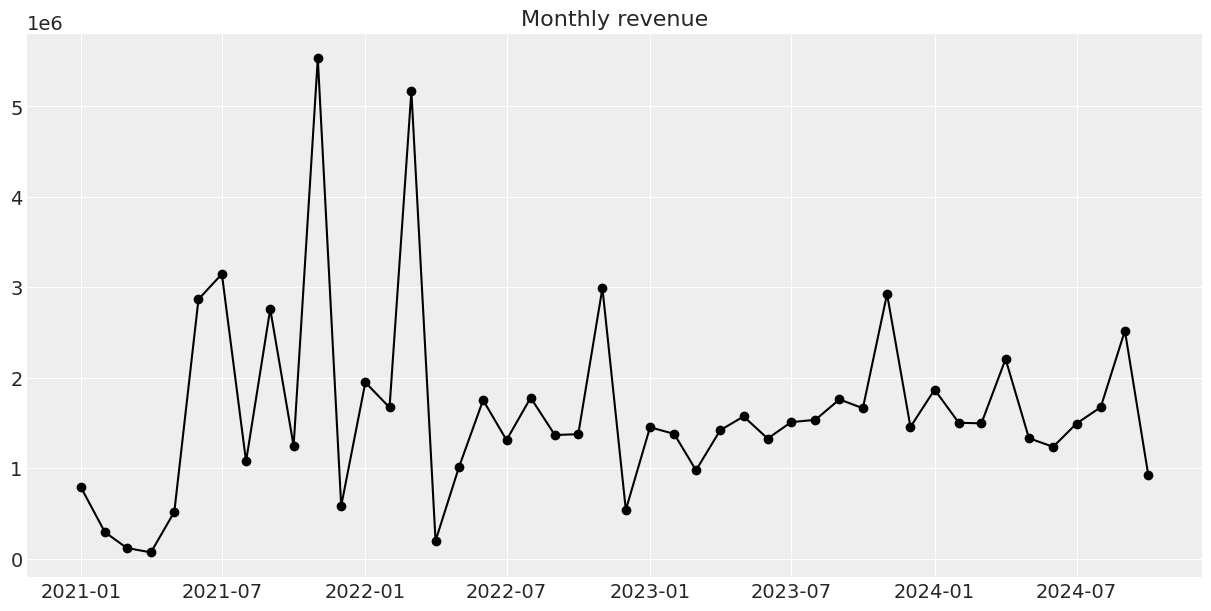

In [9]:
plt.figure(figsize=(12,6))
plt.plot(
    transactions.groupby(['MONTH'])['FULL_REVENUE'].sum(),
    color = "black",
    marker = 'o'
)
plt.title("Monthly revenue")
plt.show()

We pivot our transactions-view dataframe into a cohort-view dataframe. For each cohort and each period, we observe the number of active users and revenue.

In [10]:
cohort = project_utils.preprocess_transactions_to_cohort(transactions)
cohort

,cohort,period,n_active_users,revenue,n_users,age,cohort_age,retention,revenue_per_user,revenue_per_active_user
0,2021-01-01,2021-01-01,4795.0,793272.36,4795.0,1386.0,0.0,1.000000,165.437406,165.437406
1,2021-01-01,2021-02-01,201.0,28250.62,4795.0,1386.0,31.0,0.041919,5.891683,140.550348
2,2021-01-01,2021-03-01,126.0,23775.12,4795.0,1386.0,59.0,0.026277,4.958315,188.691429
3,2021-01-01,2021-04-01,91.0,7701.63,4795.0,1386.0,90.0,0.018978,1.606179,84.633297
4,2021-01-01,2021-05-01,418.0,49701.21,4795.0,1386.0,120.0,0.087174,10.365216,118.902416
...,...,...,...,...,...,...,...,...,...,...
1628,2024-10-01,2025-06-01,NaN,NaN,1076.0,17.0,243.0,NaN,NaN,NaN
1629,2024-10-01,2025-07-01,NaN,NaN,1076.0,17.0,273.0,NaN,NaN,NaN
1630,2024-10-01,2025-08-01,NaN,NaN,1076.0,17.0,304.0,NaN,NaN,NaN
1631,2024-10-01,2025-09-01,NaN,NaN,1076.0,17.0,335.0,NaN,NaN,NaN


<Axes: xlabel='period', ylabel='cohort'>

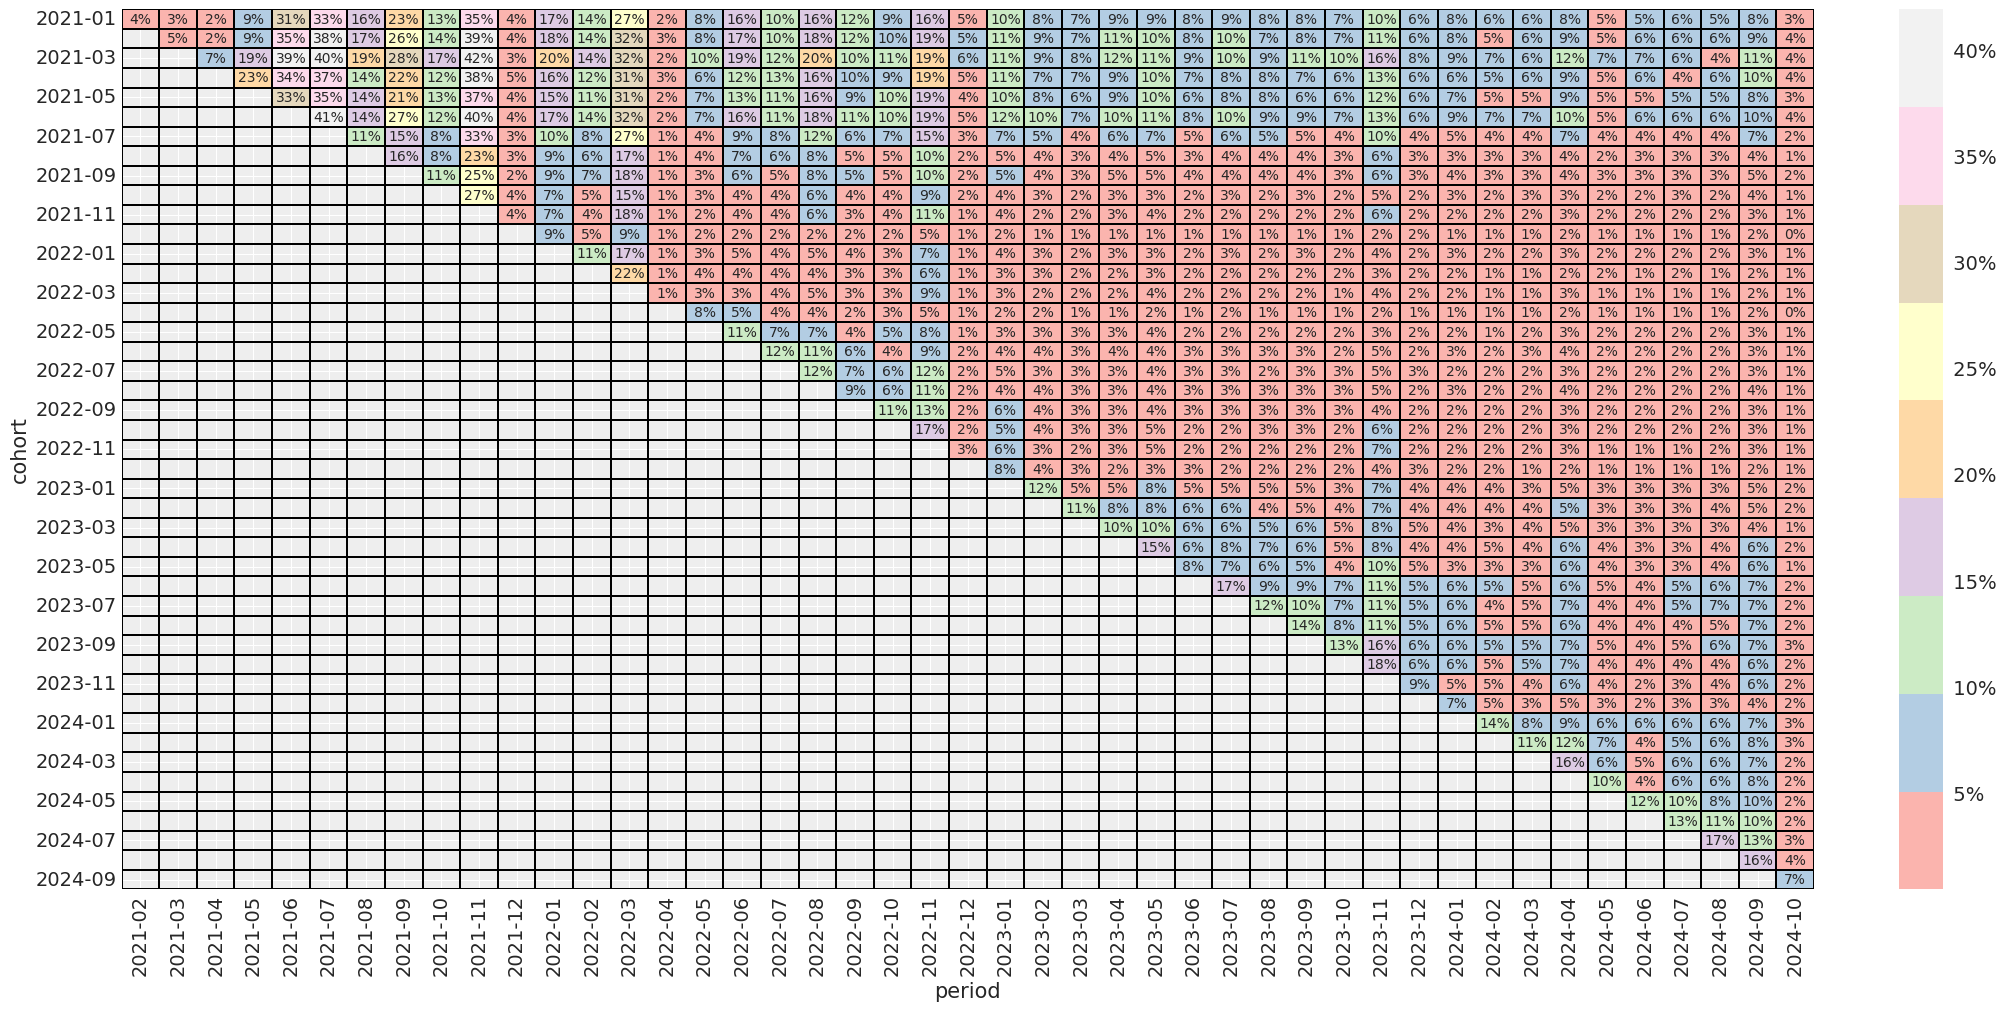

In [11]:
fig, ax = plt.subplots(figsize = (20, 10))
fmt = lambda x, _ : f"{x: 0.0%}"
max_cohort = cohort['cohort'].max().strftime("%Y-%m-%d")

cohort.assign(
    cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
    period=lambda df: df["period"].dt.strftime("%Y-%m"),
).query(
        "cohort_age != 0 & period < @max_cohort" 
).filter(
    ["cohort", "period", "retention"]
).pivot(
    index = "cohort",
    columns = "period",
    values = "retention"
).pipe(
    (sns.heatmap, "data"),
    cmap="Pastel1",
    linewidths=0.2,
    linecolor="black",
    annot=True,
    fmt="0.0%",
    cbar_kws={"format": mtick.FuncFormatter(fmt)},
    ax=ax,
)

## BART Modeling

We use data up to June 1st, 2023 as training. All subsequent data is used for testing.

The interface also allows us to limit training data or testing data to a specified time period before / after the cutoff date.

In [12]:
cutoff = datetime.datetime(2023, 6, 1)
train_df, test_df = project_utils.custom_train_test_split(cutoff, cohort)

In [13]:
train_features = project_utils.preprocess_train_test_data(train_df, mode = "train")
for key in train_features.keys():
    print(f"{key}: {type(train_features[key])}")

obs_idx: <class 'numpy.ndarray'>
n_users: <class 'numpy.ndarray'>
n_active_users: <class 'numpy.ndarray'>
retention: <class 'numpy.ndarray'>
revenue: <class 'numpy.ndarray'>
features: <class 'list'>
x: <class 'pandas.core.frame.DataFrame'>
period: <class 'numpy.ndarray'>
cohorts: <class 'numpy.ndarray'>
cohort_idx: <class 'numpy.ndarray'>
age_scaled: <class 'numpy.ndarray'>
cohort_age_scaled: <class 'numpy.ndarray'>
cohort_encoder: <class 'sklearn.preprocessing._label.LabelEncoder'>
age_scaler: <class 'sklearn.preprocessing._data.MaxAbsScaler'>
cohort_age_scaler: <class 'sklearn.preprocessing._data.MaxAbsScaler'>
period_idx: <class 'numpy.ndarray'>
retention_logit: <class 'numpy.ndarray'>
revenue_per_user: <class 'numpy.ndarray'>
data_red_df: <class 'pandas.core.frame.DataFrame'>


The test portion is what we hope to recover, up to one year from cutoff date.

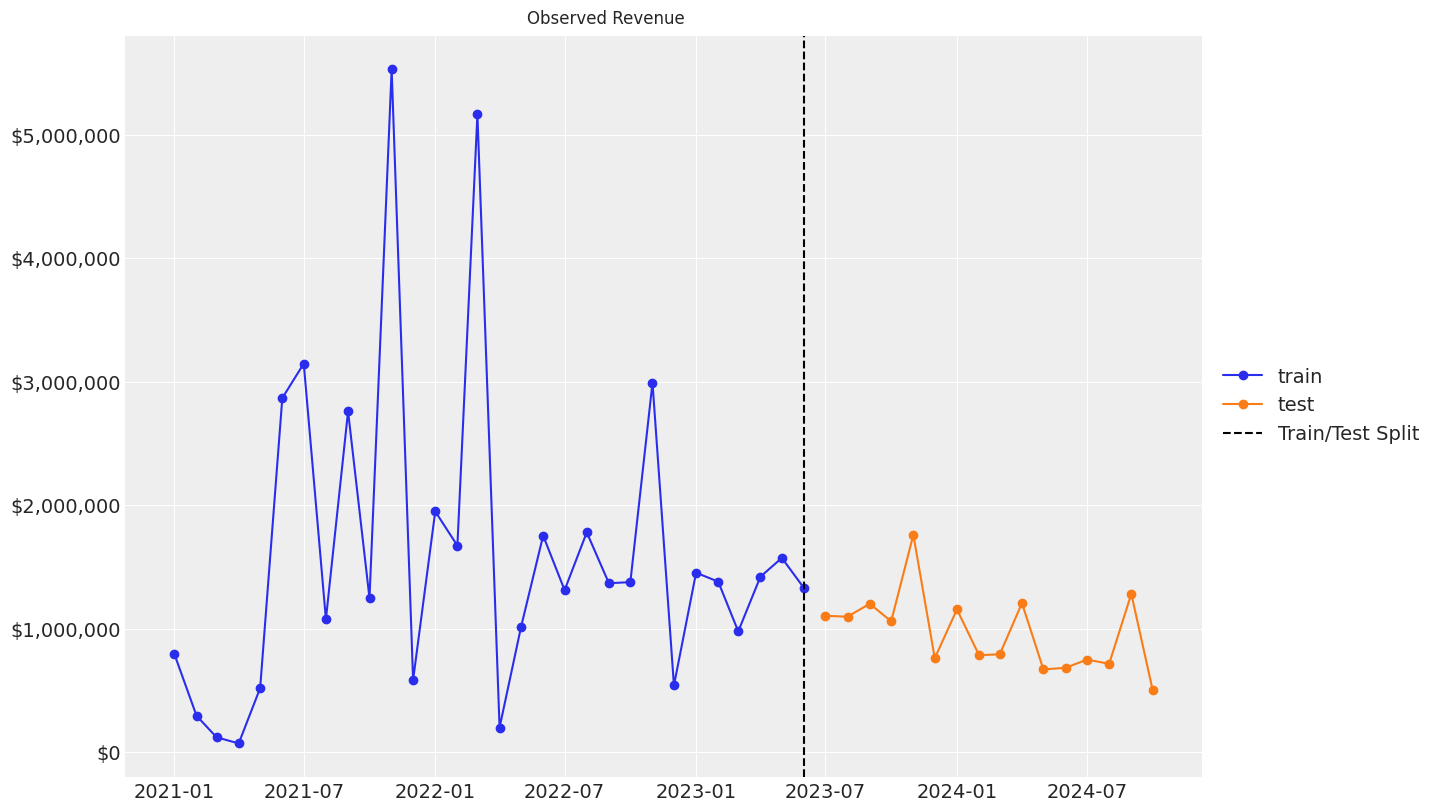

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(
    train_df.groupby(['period'])['revenue'].sum(),
    label = "train",
    color = 'C0',
    marker = 'o'
)
ax.plot(
    test_df[
        ~test_df['revenue'].isna()
    ].groupby(['period'])['revenue'].sum(),
    label = "test",
    color = 'C1',
    marker = 'o'
)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.axvline(x=cutoff, color='black', linestyle='--', label='Train/Test Split')
fig.suptitle("Observed Revenue")
fig.legend(loc = "center left", bbox_to_anchor = (1, .5))
plt.show()


We build a revenue model with BART to estimate the number of users and a Gamma component for revenue per transaction.

In [15]:
model = project_utils.build_new_model(train_features, use_default_priors=True)
model

                           intercept ~ Normal(1, 1)
                        b_age_scaled ~ Normal(0, 1)
                 b_cohort_age_scaled ~ Normal(0, 1)
        b_age_cohort_age_interaction ~ Normal(0, 1)
                       b_seasonality ~ Normal(0, 1)
       b_seasonality_age_interaction ~ Normal(0, 1)
b_seasonality_cohort_age_interaction ~ Normal(0, 1)
                                  mu ~ BART(<shared>, <constant>, 50, 0.95, 2)
                                   p ~ Deterministic(f(mu))
                             lam_log ~ Deterministic(f(b_seasonality_cohort_age_interaction, b_seasonality_age_interaction, b_seasonality, intercept, b_age_cohort_age_interaction, b_cohort_age_scaled, b_age_scaled))
                                 lam ~ Deterministic(f(b_seasonality_cohort_age_interaction, b_seasonality_age_interaction, b_seasonality, intercept, b_age_cohort_age_interaction, b_cohort_age_scaled, b_age_scaled))
            n_active_users_estimated ~ Binomial(<shared>, f(mu))


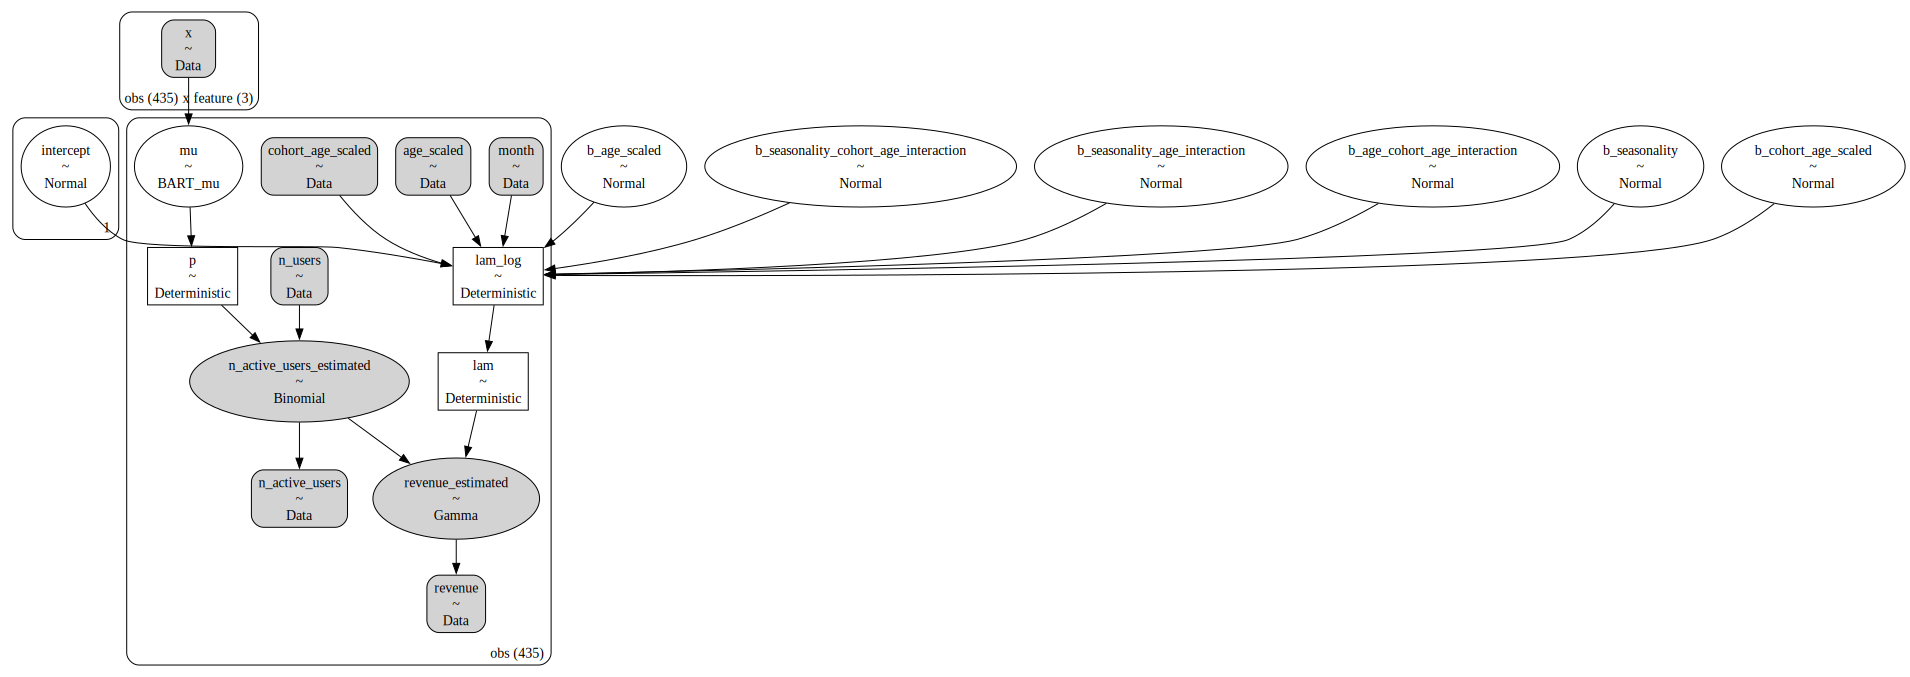

In [16]:
model.to_graphviz()

In [17]:
model, idata, pos_predictive = project_utils.fit_model(model)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Posterior predictive check:

[Text(0.5, 1.0, 'Posterior Predictive Check (Revenue)'),
 None,
 Text(0.5, 0, 'likelihood (revenue) - log scale'),
 (1, 1473133.0678904518)]

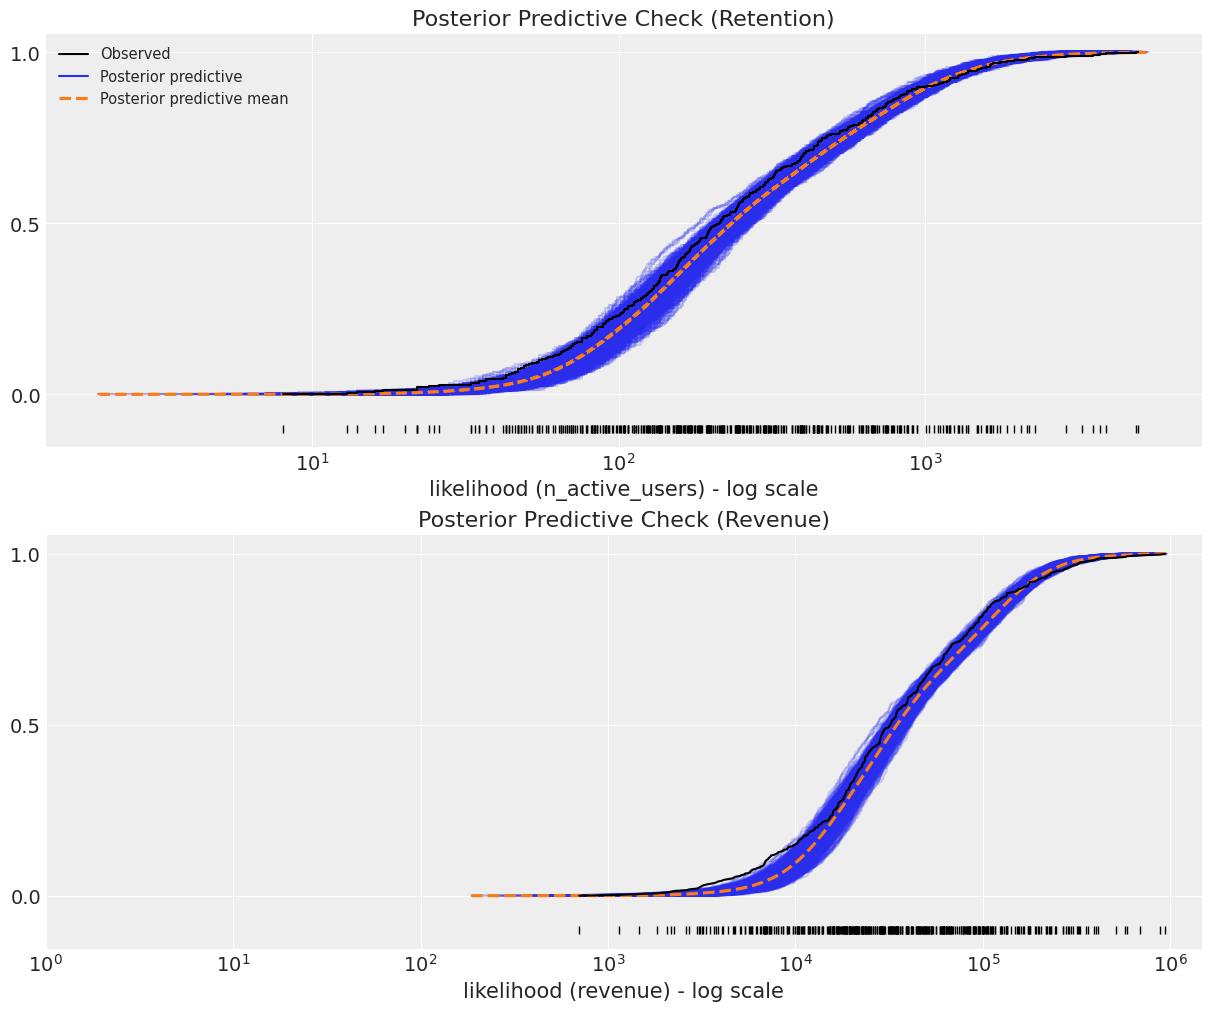

In [18]:
ax = az.plot_ppc(
    data=pos_predictive,
    kind="cumulative",
    observed_rug=True,
    grid=(2, 1),
    figsize=(12, 10),
    random_seed=42,
)
ax[0].set(
    title="Posterior Predictive Check (Retention)",
    xscale="log",
    xlabel="likelihood (n_active_users) - log scale",
)
ax[1].set(
    title="Posterior Predictive Check (Revenue)",
    xscale="log",
    xlabel="likelihood (revenue) - log scale",
    xlim=(1, None),
)

We verify that the model converges.

In [19]:
assert idata.sample_stats["diverging"].sum().item() == 0

We examine trace plots.

Text(0.5, 0.98, 'Model Trace')

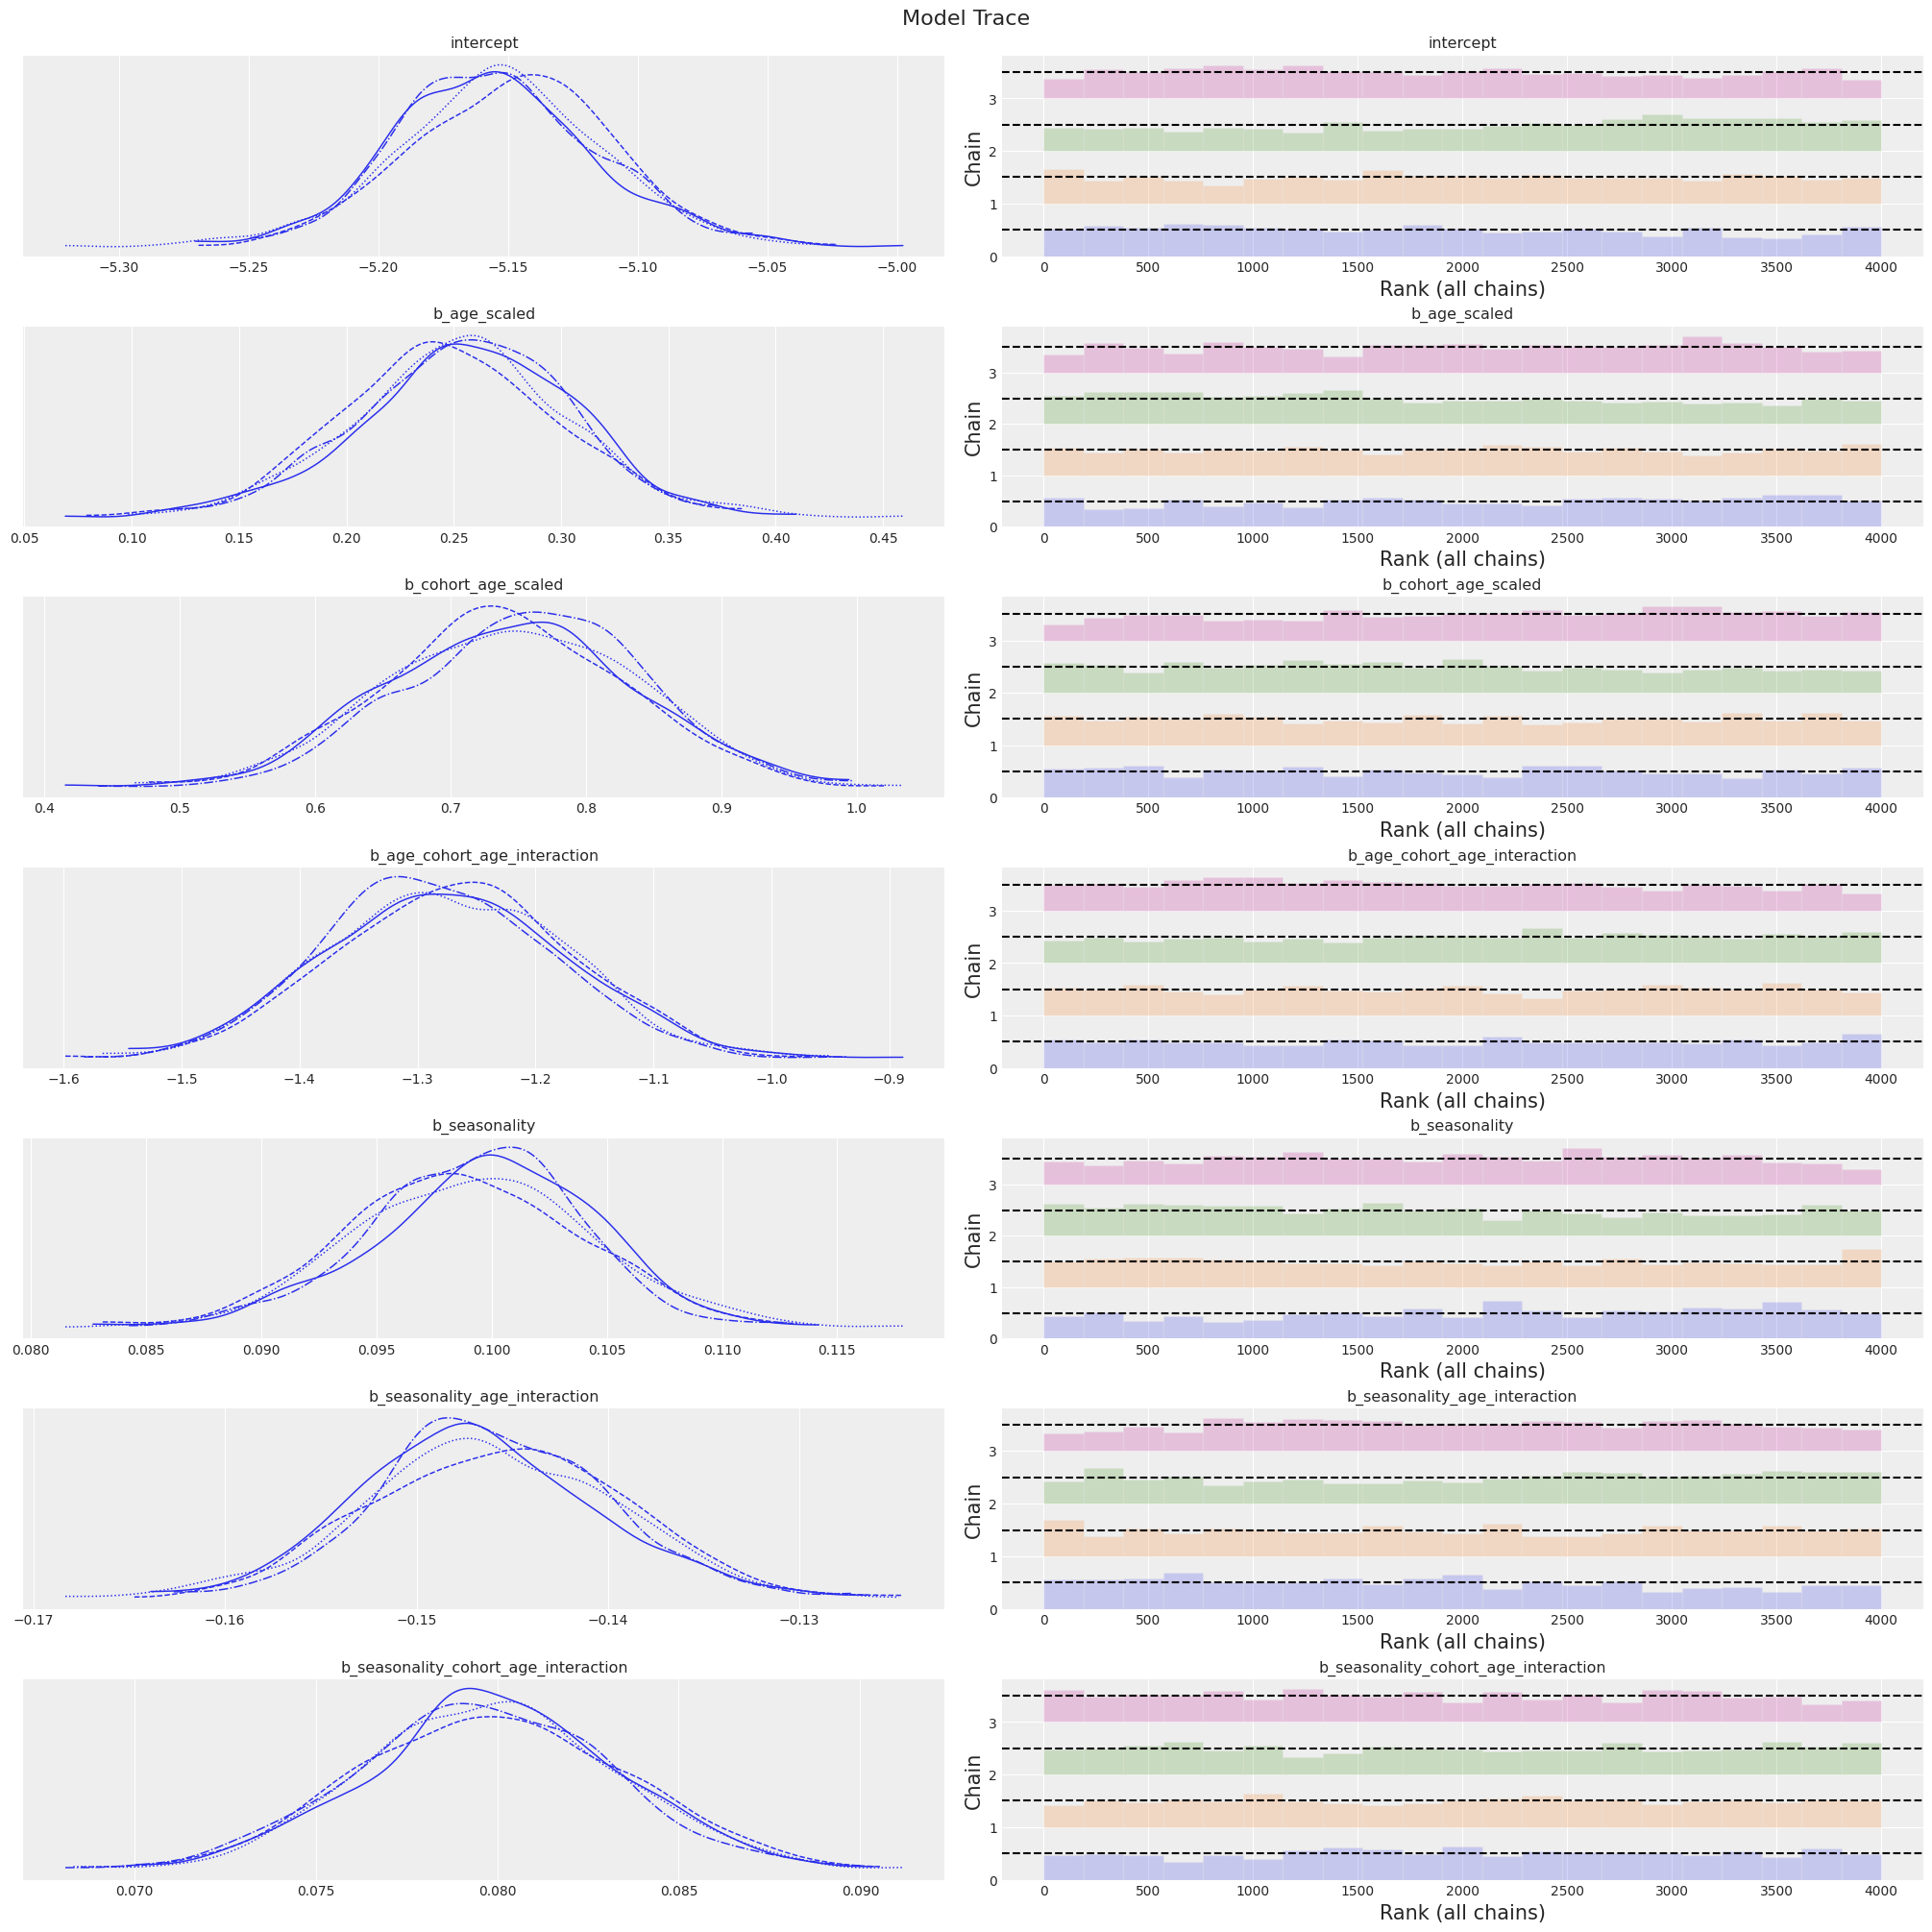

In [20]:
_ = az.plot_trace(
    data=idata,
    var_names=[
        "intercept",
        "b_age_scaled",
        "b_cohort_age_scaled",
        "b_age_cohort_age_interaction",
        "b_seasonality",
        "b_seasonality_age_interaction",
        "b_seasonality_cohort_age_interaction",
    ],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (20, 20), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16)

[Text(0.5, 1.0, 'Posterior Predictive - Revenue Mean'),
 None,
 None,
 Text(0.5, 0, 'revenue (log)'),
 Text(0, 0.5, 'posterior_revenue_mean (log)')]

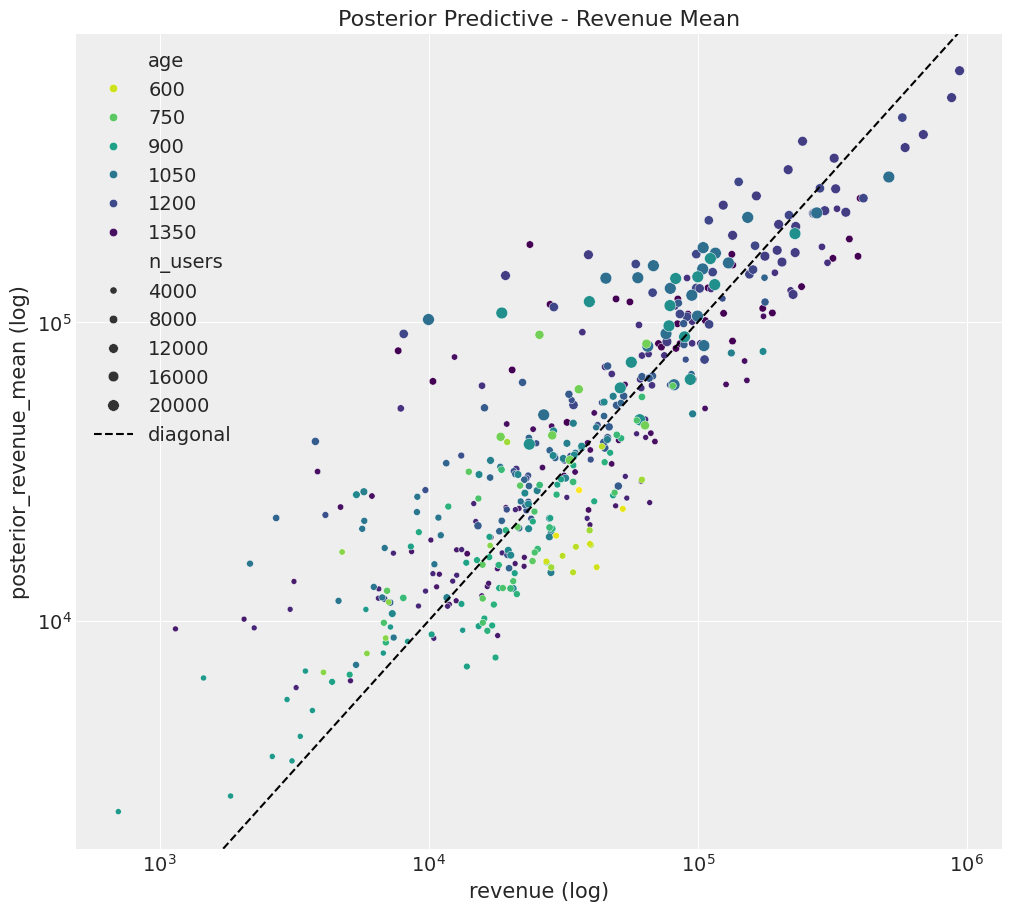

In [21]:
train_posterior_revenue_mean = az.extract(
    data=pos_predictive,
    group="posterior_predictive",
    var_names=["revenue_estimated"],
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="revenue",
    y="posterior_revenue_mean",
    data=train_features['data_red_df'].assign(posterior_revenue_mean=train_posterior_revenue_mean),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(1e5, 1e5), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    title="Posterior Predictive - Revenue Mean",
    xscale="log",
    yscale="log",
    xlabel="revenue (log)",
    ylabel="posterior_revenue_mean (log)",
)

We preprocess our test features.

In [22]:
test_features = project_utils.preprocess_train_test_data(
    test_df,
    mode="test",
    seen_cohorts = train_features['cohorts'],
    cohort_encoder = train_features['cohort_encoder'],
    age_scaler = train_features['age_scaler'],
    cohort_age_scaler= train_features['cohort_age_scaler']
)

for key in test_features.keys():
    print(f"{key}: {type(test_features[key])}")

obs_idx: <class 'numpy.ndarray'>
n_users: <class 'numpy.ndarray'>
n_active_users: <class 'numpy.ndarray'>
retention: <class 'numpy.ndarray'>
revenue: <class 'numpy.ndarray'>
features: <class 'list'>
x: <class 'pandas.core.frame.DataFrame'>
period: <class 'numpy.ndarray'>
cohorts: <class 'NoneType'>
cohort_idx: <class 'numpy.ndarray'>
age_scaled: <class 'numpy.ndarray'>
cohort_age_scaled: <class 'numpy.ndarray'>
cohort_encoder: <class 'NoneType'>
age_scaler: <class 'NoneType'>
cohort_age_scaler: <class 'NoneType'>
period_idx: <class 'NoneType'>
retention_logit: <class 'NoneType'>
revenue_per_user: <class 'NoneType'>
data_red_df: <class 'pandas.core.frame.DataFrame'>


We draw new predictions using test features.

In [23]:
model, idata = project_utils.draw_new_predictions(model, test_features, idata)

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

We extract our train and teste fit with a helper function.

In [38]:
combined_data, _, _ = project_utils.process_idata_posterior_predictive_for_plotting(
    idata = idata,
    posterior_predictive=pos_predictive,
    train_data_red_df=train_features['data_red_df'],
    test_data_red_df=test_features['data_red_df']
)
combined_data['cutoff'] = [cutoff for _ in range(combined_data.shape[0])]
combined_data.reset_index(inplace=True)

In [32]:
forward_revenue = project_utils.calculate_forward_revenue(combined_data, months = [3, 6, 12])
evaluations = project_utils.evaluate_predictions(combined_data)

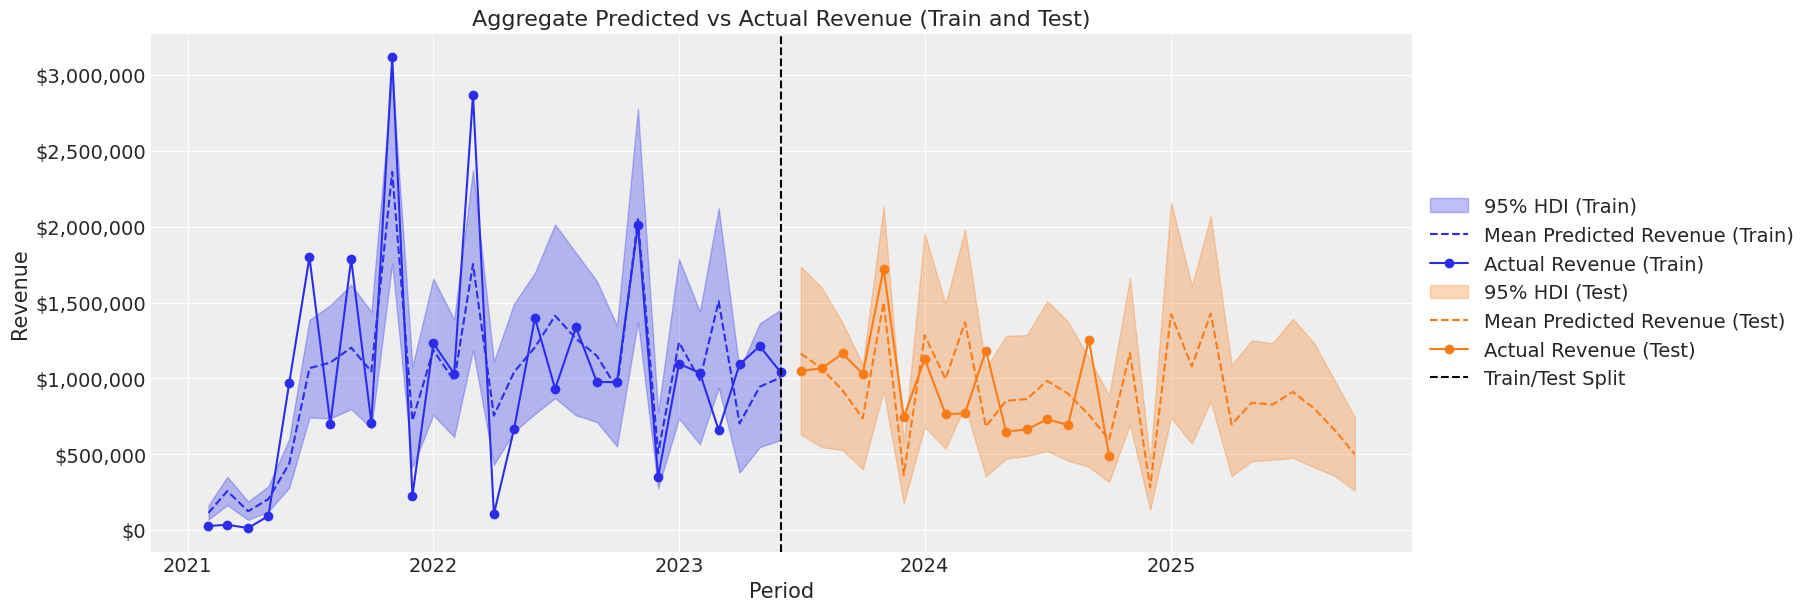

In [39]:
fig, ax = plt.subplots(figsize = (18, 6))
project_utils.plot_monthly_revenue(combined_data, ax = ax)

We are interested in the 3, 6, and 12 months forward revenue from the cutoff date.

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_13355/2510412785.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


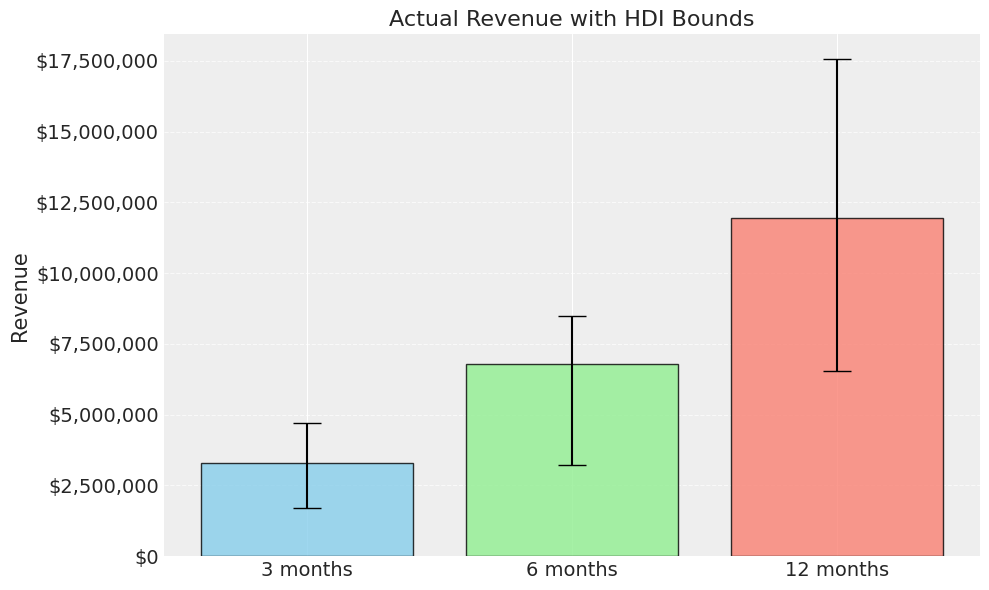

In [77]:
time_horizons = ["3 months", "6 months", "12 months"]
actuals = [forward_revenue[f"{horizon} actual"].values[0] for horizon in time_horizons]
hdi_lowers = [forward_revenue[f"{horizon} HDI Lower"].values[0] for horizon in time_horizons]
hdi_uppers = [forward_revenue[f"{horizon} HDI Upper"].values[0] for horizon in time_horizons]

lower_errors = [actual - lower for actual, lower in zip(actuals, hdi_lowers)]
upper_errors = [upper - actual for actual, upper in zip(actuals, hdi_uppers)]
error = [lower_errors, upper_errors]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(time_horizons))

ax.bar(
    x,
    actuals,
    yerr=error,
    capsize=10,
    color=["skyblue", "lightgreen", "salmon"],
    edgecolor="black",
    alpha=0.8,
)

ax.set_xticks(x, time_horizons)
ax.set_ylabel("Revenue")
ax.set_title("Actual Revenue with HDI Bounds")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()


## Backtesting

We repeat the step above at monthly intervals starting from 2021 June, and examine predicted vs realized forward revenue at each cutoff period.

In [4]:
date_range = pd.date_range(
    "2021-06-01",
    "2024-10-01",
    freq = "1M"
)


# We log predictions for subsequent plotting
log_file_path = './model_log_0114.csv'

log_df = pd.DataFrame(
    columns = [
        'Dataset', 
        'Predicted Revenue', 
        'Actual Revenue', 
        'hdi_lower',
        'hdi_upper', 
        'cutoff'
    ]
)
log_df.to_csv(log_file_path)

transactions = project_utils.load_transactions('./transactions.csv')
transactions = project_utils.preprocess_transactions(transactions)
cohort = project_utils.preprocess_transactions_to_cohort(transactions)

# For this attempt, we use fitted posteriors as priors for the subsequent cutoff date
latest_posteriors = {}

for i, cutoff in enumerate(date_range):
    cutoff = datetime.datetime.strftime(cutoff, format = "%Y-%m-%d")
    print(f"Processing {cutoff}")
    train_df, test_df = project_utils.custom_train_test_split(cutoff, cohort)
    train_features = project_utils.preprocess_train_test_data(train_df, mode = "train")

    if i == 0:
        model = project_utils.build_new_model(train_features, use_default_priors=True)
    else:
        model = project_utils.build_new_model(
            train_features, 
            use_default_priors=True,
            informative_priors= latest_posteriors
        )
    model, idata, pos_predictive = project_utils.fit_model(model)

    latest_posteriors = project_utils.extract_posteriors(idata)

    test_features = project_utils.preprocess_train_test_data(
        test_df,
        mode="test",
        seen_cohorts = train_features['cohorts'],
        cohort_encoder = train_features['cohort_encoder'],
        age_scaler = train_features['age_scaler'],
        cohort_age_scaler= train_features['cohort_age_scaler']
    )
    model, idata = project_utils.draw_new_predictions(model, test_features, idata)

    combined_data, _, __ = project_utils.process_idata_posterior_predictive_for_plotting(
        idata = idata,
        posterior_predictive=pos_predictive,
        train_data_red_df=train_features['data_red_df'],
        test_data_red_df=test_features['data_red_df']
    )
    combined_data['cutoff'] = [cutoff for _ in range(combined_data.shape[0])]
    combined_data.reset_index(inplace=True)

    log_df = pd.read_csv(log_file_path, index_col=0)
    log_df = pd.concat([log_df, combined_data], ignore_index=True)
    log_df.to_csv(log_file_path)


/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_33311/3199102666.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


Processing 2021-06-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-07-31


/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_33311/3199102666.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, combined_data], ignore_index=True)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-08-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-09-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-10-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-11-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-12-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-01-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-02-28


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-03-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-04-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-05-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-06-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-07-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-08-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-09-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-10-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-11-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2022-12-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-01-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-02-28


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-03-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-04-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-05-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-06-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-07-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-08-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-09-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-10-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-11-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2023-12-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-01-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-02-29


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-03-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-04-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-05-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-06-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-07-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-08-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2024-09-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

In [5]:
log_df = pd.read_csv('./model_log_0114.csv', index_col = 0)
log_df['period'] = pd.to_datetime(log_df['period'], format = "mixed")
log_df['cutoff'] = pd.to_datetime(log_df['cutoff'], format = "mixed")

forward_revenue = project_utils.calculate_forward_revenue(log_df, months = [3, 6, 12])
evaluations = project_utils.evaluate_predictions(log_df)


Predictions prior to 2022 are extremely off, we filter out the first 2 months and start plotting from 2021-Sept onwards.

/Users/fanghema/Desktop/Deep Ocean - BART/project_utils.py:1309: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


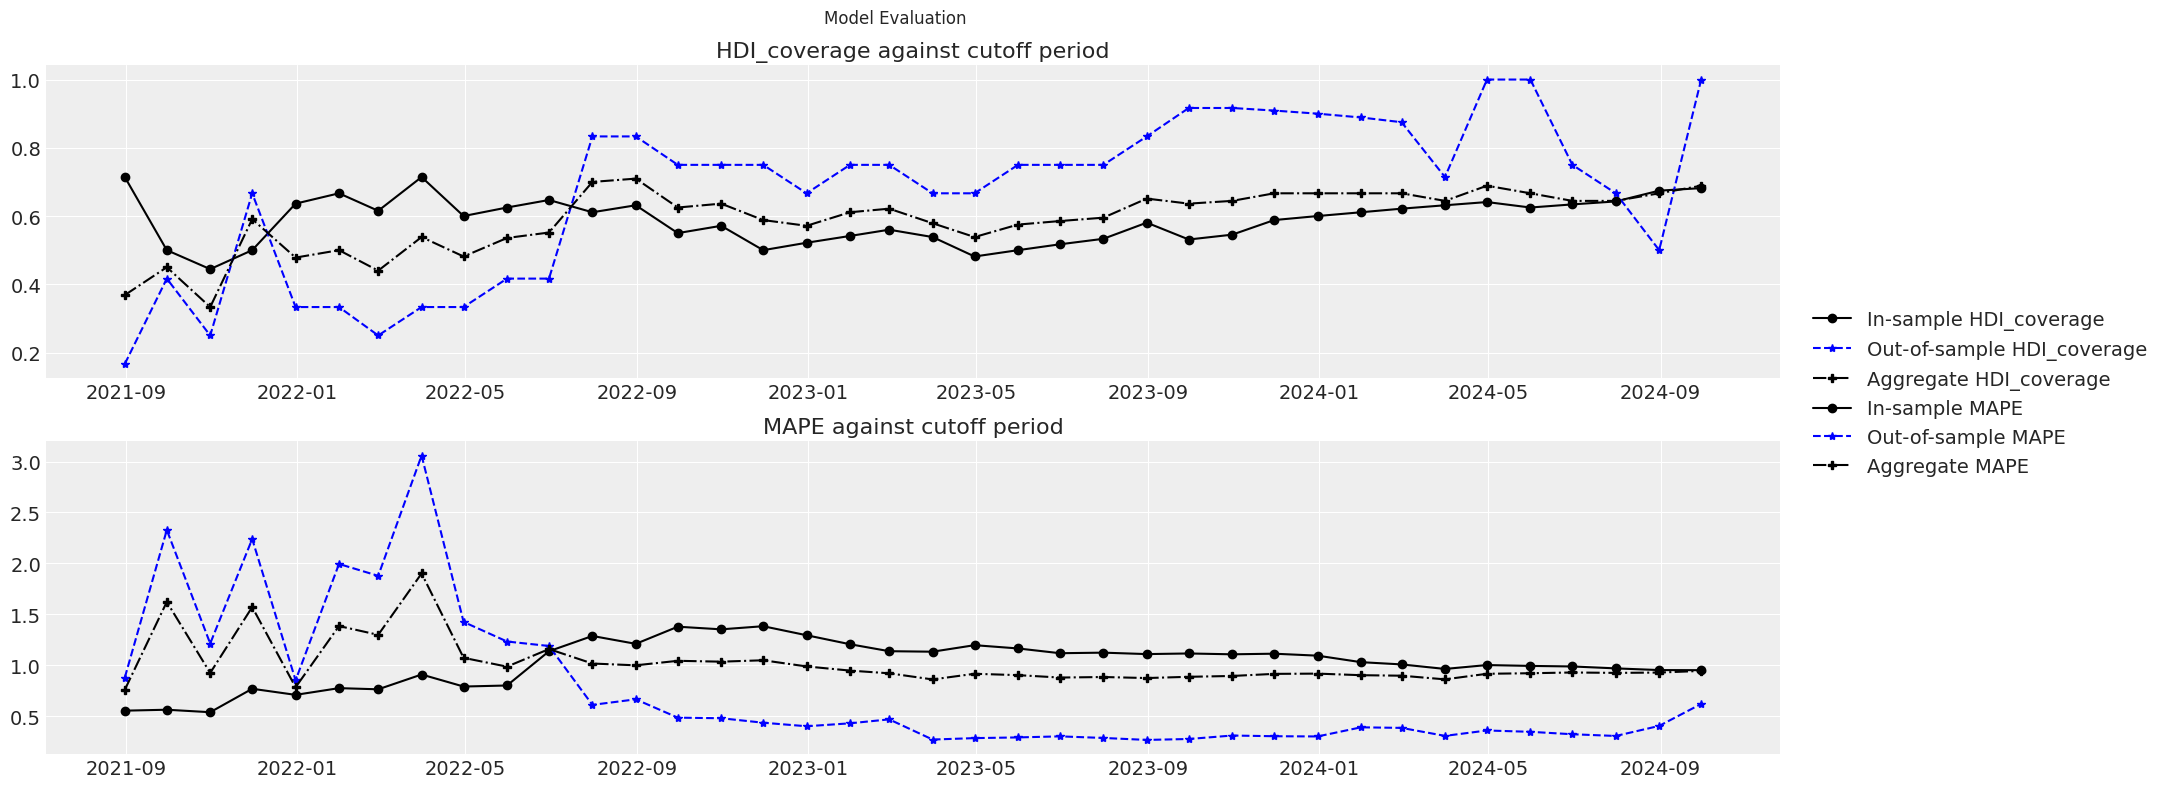

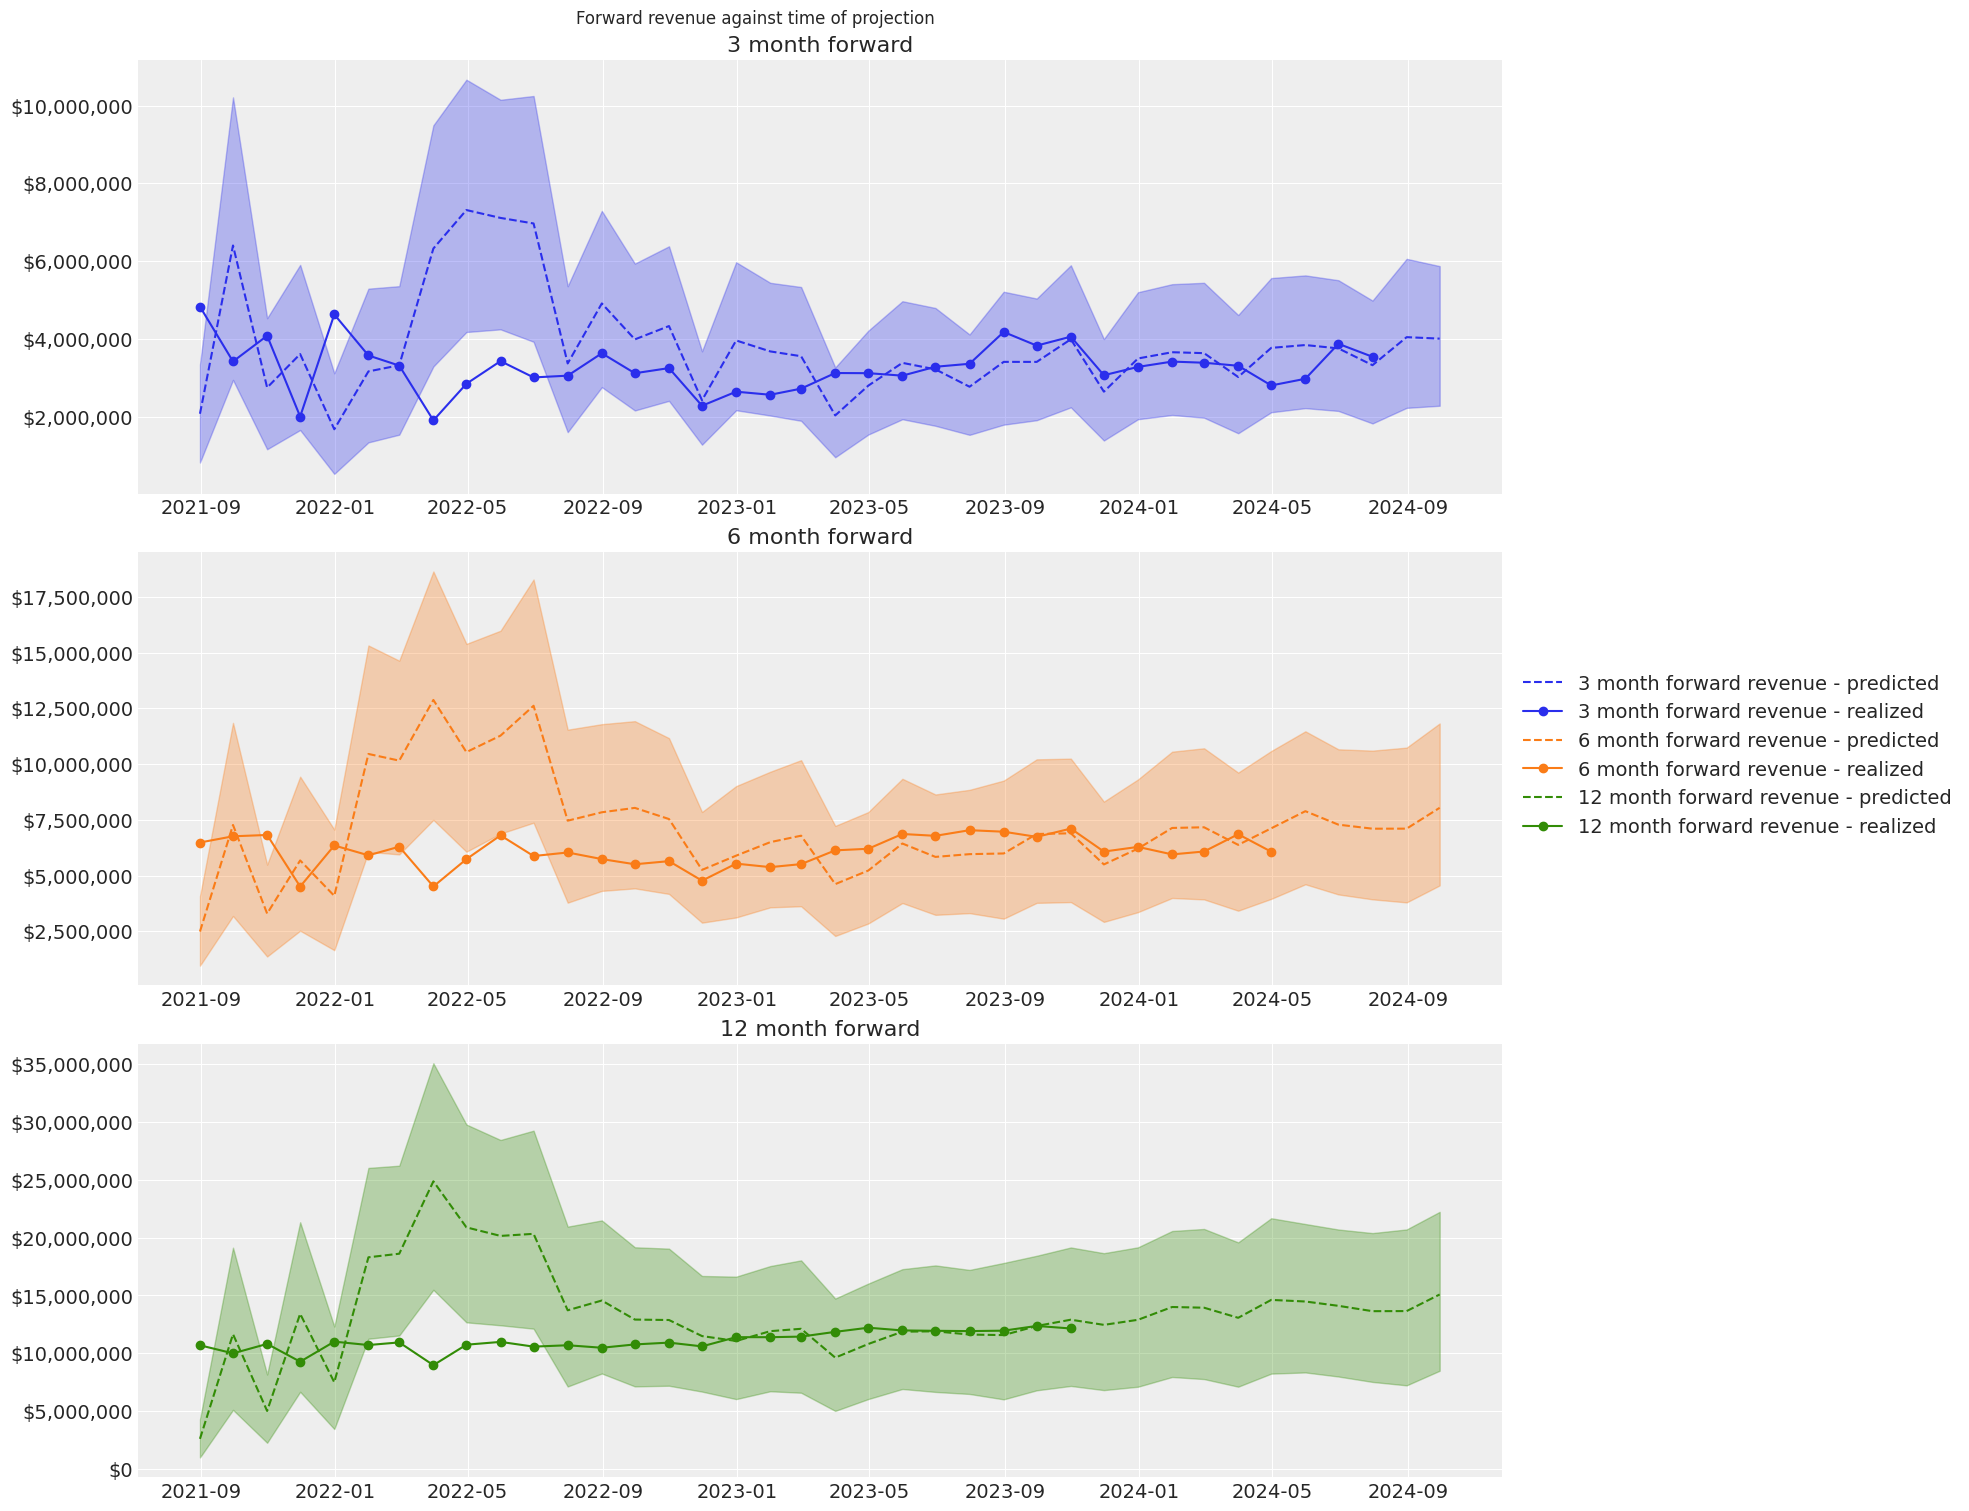

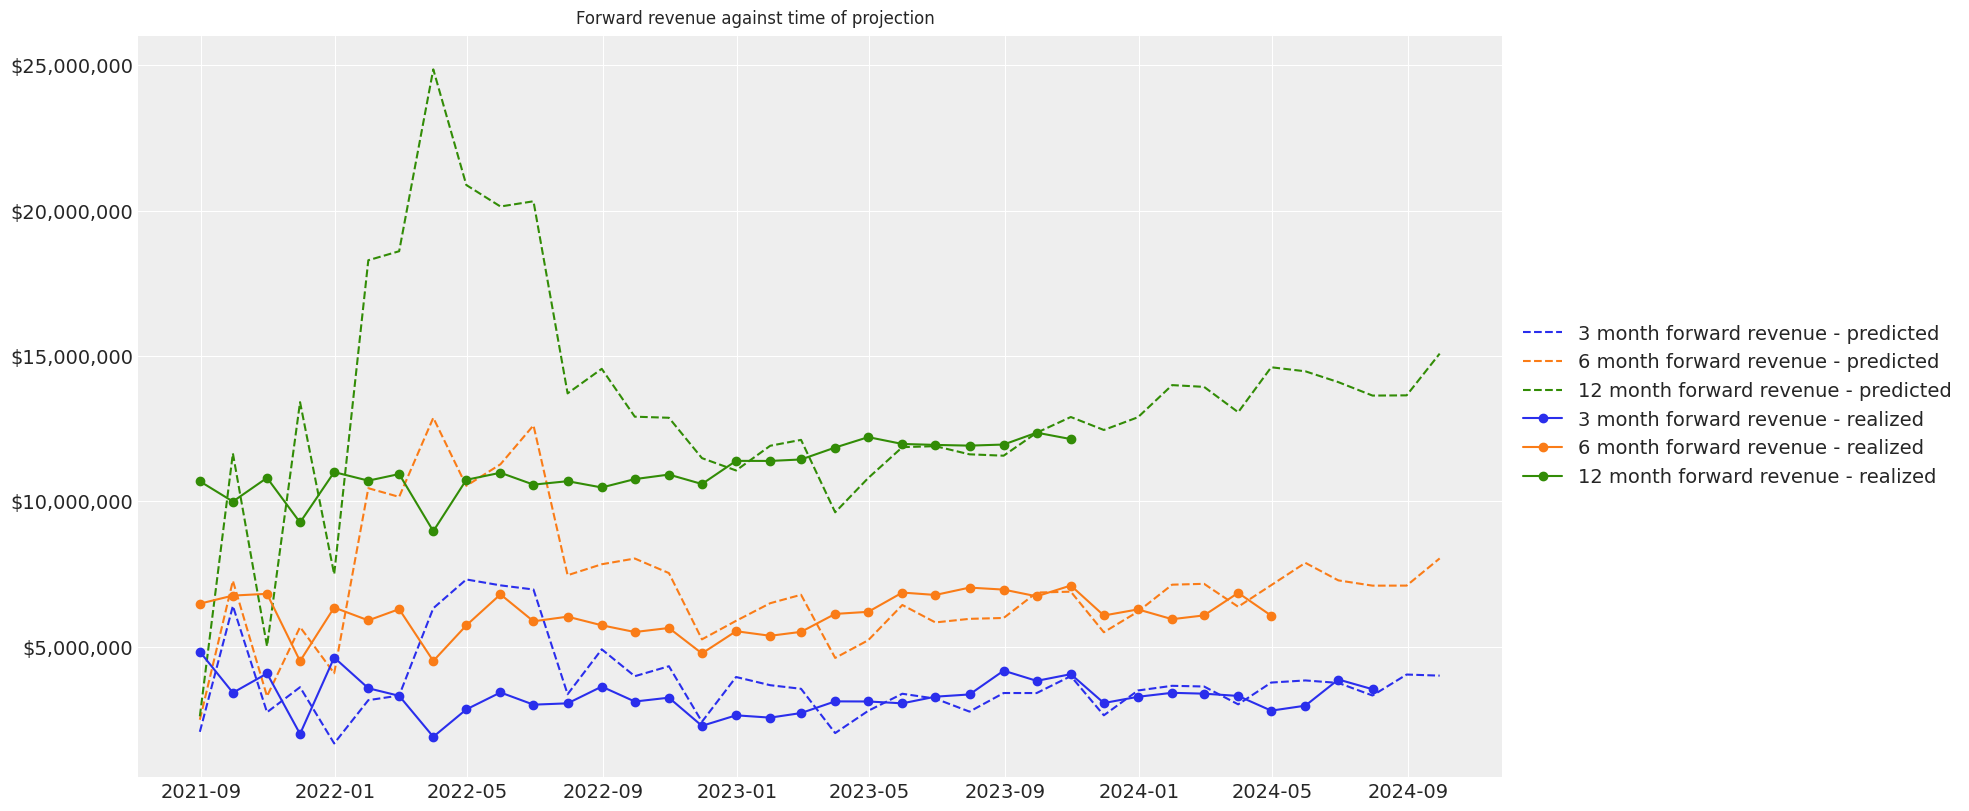

In [6]:
project_utils.plot_evaluations(evaluations=evaluations.iloc[2:, :])
project_utils.plot_forward_revenue(forward_revenue=forward_revenue.iloc[2:, :], show_CI=True)
project_utils.plot_forward_revenue(forward_revenue=forward_revenue.iloc[2:, :], show_CI=False)